# Yelp Photo Classifier

This project focuses on developing a sophisticated computer vision system to classify business photos from Yelp into four distinct categories: Food, Drink, Interior, and Exterior. Leveraging deep learning techniques, the project explores various approaches to build and optimize a high-performance image classification model.

If you have trouble in installing tensorflow in your computer, you may consider using Google Colab for this project.

## Part 1 How Yelp Uses Deep Learning to Classify Business Photos?

Yelp hosts tens of millions of photos uploaded by Yelpers from all around the world. The wide variety of these photos provides a rich window into local businesses, a window we’re only just peeking through today.

One way we’re trying to open that window is by developing a photo understanding system which allows us to create semantic data about individual photographs. The data generated by the system has been powering our recent launch of tabbed photo browsing as well as our first attempts at content-based photo diversification.

You can check more details about Yelp's practices at [here](https://engineeringblog.yelp.com/2015/10/how-we-use-deep-learning-to-classify-business-photos-at-yelp.html)


![food](https://engineeringblog.yelp.com/images/posts/2015-10-14-photo-classification/image02.png)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from PIL import Image
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inlinec

Let's first upload the file images.npy and labels.npy and load the images dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images = np.load('/content/drive/My Drive/Colab Notebooks/Assignment3_DL_2324/images.npy') # SHAPE: (1024, 256, 256, 3) -> (N_SAMPLES, HEIGHT, WIDTH, CHANNELS)
labels = np.load('/content/drive/My Drive/Colab Notebooks/Assignment3_DL_2324/labels.npy') # SHAPE: (1024,) -> (N_SAMPLES,). Label encoded: 0, 1, 2, 3

print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print('Labels match the image at the respective 0 to 1024 position.')

Images shape: (1024, 256, 256, 3)
Labels shape: (1024,)
Labels match the image at the respective 0 to 1024 position.


There are four types of the images on Yelp: Food, Drink, Interior and Exterior

In [ ]:
np.unique(labels)

array([0, 1, 2, 3])

We visualize some random images from the dataset below:

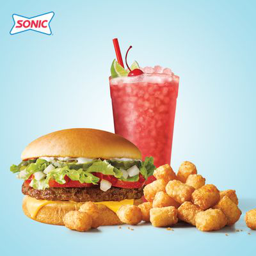

In [ ]:
# food: class 0

Image.fromarray(images[5])

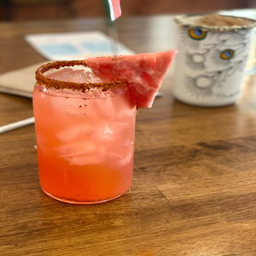

In [ ]:
# drink: class 1

Image.fromarray(images[3])

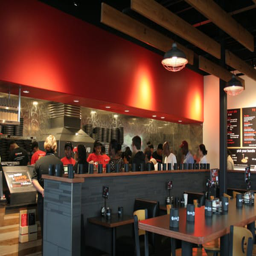

In [ ]:
# interior: class 2

Image.fromarray(images[7])

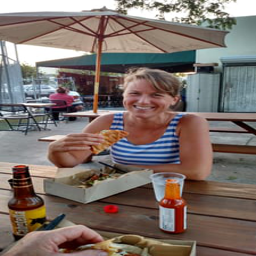

In [ ]:
# exterior: class 3

Image.fromarray(images[8])

### Part 1.1 Training a deep neural network

Practice training a deep neural network on the Yelp image dataset


Build a Deep Neural Network (DNN) with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this question), using the RELU activation function.

Using Adam optimization, train the network on the dataset. Donot forget define your input and output layers.

Train the model for 100 epochs and use test set as the validation data during the training, explain how many parameters does the model have and whether the model will experience overfitting. You may consider plotting the losses and accuracy over epochs.

In [ ]:
# Convert the datasets to a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

# Shuffle the dataset and split into training and validation sets
dataset = dataset.shuffle(buffer_size=len(images), seed=123, reshuffle_each_iteration=False)
train_size = int(0.8 * len(images))  # 80% for training
test_size = len(images) - train_size # 20% for tasting that we will use as validation set

train_d = dataset.take(train_size)
test_d = dataset.skip(train_size)

# Batch and prefetch for performance
batch_size = 32
img_height = 256
img_width = 256

# Batch and prefetch
train_ds = train_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Check one batch of the dataset
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 256, 256, 3)
(32,)


In [ ]:
#Tailoring the learning rate
# Constants
TOTAL_IMAGES = 1024
NUM_EPOCHS = 100
STEPS_PER_EPOCH = TOTAL_IMAGES // batch_size

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.0005,
  decay_steps=STEPS_PER_EPOCH * NUM_EPOCHS,
  decay_rate=0.5,
  staircase=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

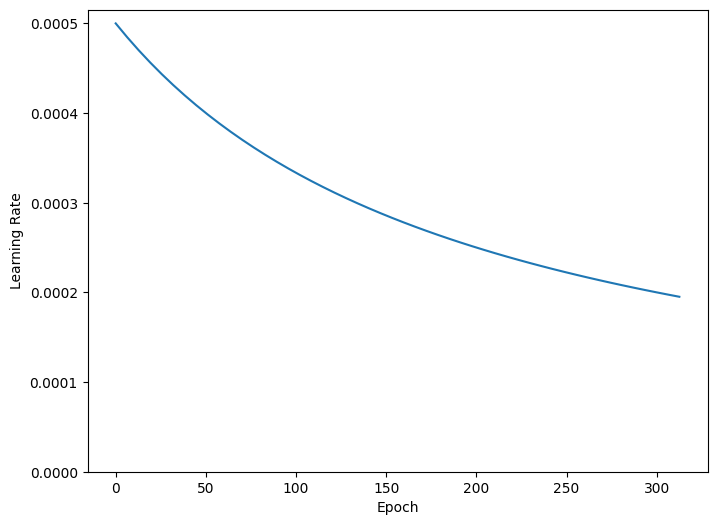

In [ ]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
#Creation of the model
num_classes = len(np.unique(labels))

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
])

model.add(layers.Dense(100, activation='relu'))

for _ in range(19):
    model.add(layers.Dense(100, activation='relu'))

# Output layer for multi-class classification, using softmax
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 100)               19660900  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               1

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/100
26/26 [==============================] - 6s 114ms/step - loss: 1.3840 - accuracy: 0.2625 - val_loss: 1.3685 - val_accuracy: 0.2927
Epoch 2/100
26/26 [==============================] - 2s 94ms/step - loss: 1.3534 - accuracy: 0.3199 - val_loss: 1.3437 - val_accuracy: 0.3707
Epoch 3/100
26/26 [==============================] - 2s 95ms/step - loss: 1.3253 - accuracy: 0.3480 - val_loss: 1.3127 - val_accuracy: 0.3659
Epoch 4/100
26/26 [==============================] - 2s 95ms/step - loss: 1.2426 - accuracy: 0.3810 - val_loss: 1.1887 - val_accuracy: 0.4683
Epoch 5/100
26/26 [==============================] - 2s 95ms/step - loss: 1.1745 - accuracy: 0.4225 - val_loss: 1.2017 - val_accuracy: 0.4439
Epoch 6/100
26/26 [==============================] - 2s 95ms/step - loss: 1.1520 - accuracy: 0.4518 - val_loss: 1.1533 - val_accuracy: 0.4683
Epoch 7/100
26/26 [==============================] - 2s 95ms/step - loss: 1.1104 - accuracy: 0.4933 - val_loss: 1.1481 - val_accuracy: 0.4732
Epoch

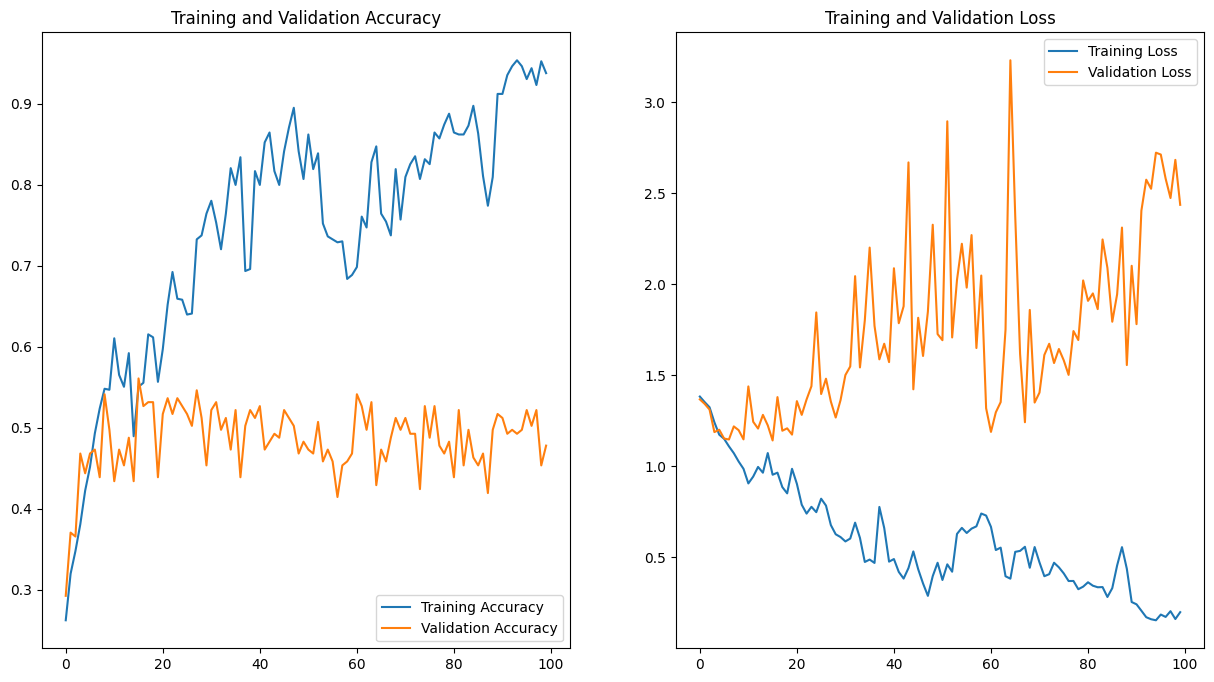

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Basiline Model
test_loss, test_accuracy = model.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Number of parameters:',  model.count_params())

7/7 [==============================] - 0s 9ms/step - loss: 2.4376 - accuracy: 0.4780
Test loss: 2.4375603199005127
Test accuracy: 0.47804877161979675
Number of parameters: 19853204


### Observations:
The model has 19853204 parameters.

The training and validation plots for the deep neural network, constructed with an excessively deep architecture of 20 hidden layers, manifest clear indications of overfitting. As the training progresses through 100 epochs, we observe that the training accuracy improves steadily, which typically would suggest a model is learning effectively. However, the validation accuracy does not mirror this improvement beyond a certain point, leveling off significantly, a classic hallmark of overfitting. Furthermore, the validation loss exhibits erratic behavior, with marked spikes and an overall lack of a declining trend, underscoring the model's challenges in generalizing to unseen data. The early epochs show promise with both accuracies rising in tandem, but this trend falters as training extends, revealing that while the model is becoming proficient in memorizing the training data, as evidenced by the descending training loss, it fails to sustain this performance on the validation set.

### Part 1.2

Try reduce the overfitting and improve the model performance. You can try the bag of tricks to the model from the class. This may include one or more techniques such as **weight regularization**, **batch normalization**, **dropout**, **Early stopping**, etc. You should perform ``ablation study``, a common techniqued used in machine learning community to show the effectivess of the introduced technique. In other words, show your step-by-step improvement by including these techniques and repeat the repeat the previous training process. Explain whether and how these techniques help achieve a better result. You may consider stopping improving the model by making it at least 10% better than the previous model architecture.

In [ ]:
#Adding early stopping for faster trianing
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [ ]:
#Plotting function
model_histories = {}
def plot_model_histories(model_histories):
    for metric in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
        plt.figure(figsize=(12, 6))
        for model_title, history in model_histories.items():
            plt.plot(history[metric], label=f'{model_title} {metric}')
        plt.title(f'Models {metric.capitalize()}')
        plt.ylabel('Loss' if 'loss' in metric else 'Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()


model_histories['Baseline Model'] = history.history

In [ ]:
#Data Augmentation
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Define data augmentation layers
data_augmentation = Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

# Define the model with data augmentation
augmented_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    *[layers.Dense(100, activation='relu') for _ in range(19)],
    layers.Dense(4, activation='softmax')
])

augmented_model.compile(optimizer=optimizer,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

# Train the model with data augmentation
augmented_history = augmented_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with data augmentation
augmented_test_loss, augmented_test_accuracy = augmented_model.evaluate(test_ds)
print("Data Augmented Model Test Loss:", augmented_test_loss)
print("Data Augmented Model Test Accuracy:", augmented_test_accuracy)

model_histories['Data Augmented Model'] = augmented_history.history

Epoch 1/100
26/26 [==============================] - 7s 116ms/step - loss: 1.3879 - accuracy: 0.2344 - val_loss: 1.3794 - val_accuracy: 0.2098
Epoch 2/100
26/26 [==============================] - 3s 106ms/step - loss: 1.3843 - accuracy: 0.2466 - val_loss: 1.3742 - val_accuracy: 0.3268
Epoch 3/100
26/26 [==============================] - 3s 106ms/step - loss: 1.3840 - accuracy: 0.2442 - val_loss: 1.3822 - val_accuracy: 0.2537
Epoch 4/100
26/26 [==============================] - 3s 107ms/step - loss: 1.3805 - accuracy: 0.2759 - val_loss: 1.3691 - val_accuracy: 0.2976
Epoch 5/100
26/26 [==============================] - 3s 107ms/step - loss: 1.3702 - accuracy: 0.2979 - val_loss: 1.3127 - val_accuracy: 0.4683
Epoch 6/100
26/26 [==============================] - 3s 105ms/step - loss: 1.3685 - accuracy: 0.2979 - val_loss: 1.3920 - val_accuracy: 0.2390
Epoch 7/100
26/26 [==============================] - 3s 105ms/step - loss: 1.3783 - accuracy: 0.2845 - val_loss: 1.3609 - val_accuracy: 0.3366

In [ ]:
# Define the model with Dropout
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

dropout_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    *[layers.Dense(100, activation='relu') for _ in range(19)],
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')
])

dropout_model.compile(optimizer= optimizer,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

# Train the model with Dropout
dropout_history = dropout_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with Dropout
dropout_test_loss, dropout_test_accuracy = dropout_model.evaluate(test_ds)
print("Data Dropout Model Test Loss:", dropout_test_loss)
print("Data Dropout Model Test Accuracy:", dropout_test_accuracy)

model_histories['Dropout Model'] = dropout_history.history

Epoch 1/100
26/26 [==============================] - 6s 107ms/step - loss: 1.3826 - accuracy: 0.2601 - val_loss: 1.3517 - val_accuracy: 0.2927
Epoch 2/100
26/26 [==============================] - 2s 94ms/step - loss: 1.3432 - accuracy: 0.3394 - val_loss: 1.2730 - val_accuracy: 0.4049
Epoch 3/100
26/26 [==============================] - 2s 95ms/step - loss: 1.2779 - accuracy: 0.3944 - val_loss: 1.2348 - val_accuracy: 0.4390
Epoch 4/100
26/26 [==============================] - 2s 95ms/step - loss: 1.2019 - accuracy: 0.4164 - val_loss: 1.1750 - val_accuracy: 0.4585
Epoch 5/100
26/26 [==============================] - 2s 92ms/step - loss: 1.2138 - accuracy: 0.4396 - val_loss: 1.2064 - val_accuracy: 0.5268
Epoch 6/100
26/26 [==============================] - 2s 94ms/step - loss: 1.1645 - accuracy: 0.4298 - val_loss: 1.1735 - val_accuracy: 0.4732
Epoch 7/100
26/26 [==============================] - 2s 95ms/step - loss: 1.0945 - accuracy: 0.4823 - val_loss: 1.1534 - val_accuracy: 0.5756
Epoch

In [ ]:
# Define the model with batch normalization
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

bn_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
])

# Adding the repeated layers
for _ in range(19):
    bn_model.add(layers.Dense(100, activation='relu'))
    bn_model.add(layers.BatchNormalization())

bn_model.add(layers.Dense(4, activation='softmax'))

bn_model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

# Train the model
bn_history = bn_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with batch normalization
bn_test_loss, bn_test_accuracy = bn_model.evaluate(test_ds)
print("Batch Normalization Test Loss:", bn_test_loss)
print("Batch Normalization Test Accuracy:", bn_test_accuracy)

model_histories['Batch Norm. Model'] = bn_history.history

Epoch 1/100
26/26 [==============================] - 11s 121ms/step - loss: 1.8107 - accuracy: 0.2320 - val_loss: 1.3877 - val_accuracy: 0.2000
Epoch 2/100
26/26 [==============================] - 3s 99ms/step - loss: 1.6232 - accuracy: 0.3016 - val_loss: 1.3912 - val_accuracy: 0.3073
Epoch 3/100
26/26 [==============================] - 3s 99ms/step - loss: 1.4998 - accuracy: 0.3065 - val_loss: 1.3936 - val_accuracy: 0.2390
Epoch 4/100
26/26 [==============================] - 3s 99ms/step - loss: 1.4975 - accuracy: 0.3040 - val_loss: 1.4155 - val_accuracy: 0.2927
Epoch 5/100
26/26 [==============================] - 3s 100ms/step - loss: 1.4224 - accuracy: 0.3272 - val_loss: 1.3759 - val_accuracy: 0.3073
Epoch 6/100
26/26 [==============================] - 3s 100ms/step - loss: 1.4143 - accuracy: 0.3358 - val_loss: 1.3688 - val_accuracy: 0.3268
Epoch 7/100
26/26 [==============================] - 3s 99ms/step - loss: 1.4199 - accuracy: 0.3431 - val_loss: 1.4280 - val_accuracy: 0.2829
Ep

In [ ]:
# Define the model with weight regularization
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

regularization_model = Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Flatten(),
    layers.Dense(100, activation='relu', kernel_regularizer=l2(0.0001)),
    *[layers.Dense(100, activation='relu', kernel_regularizer=l2(0.0001)) for _ in range(19)],
    layers.Dense(4, activation='softmax')
])

regularization_model.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

# Train the model with weight regularization
regularization_history = regularization_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with weight regularization
regularization_test_loss, regularization_test_accuracy = regularization_model.evaluate(test_ds)
print("Regularization Test Loss:", regularization_test_loss)
print("Regularization Test Accuracy:", regularization_test_accuracy)

model_histories['Regularization Model'] = regularization_history.history

Epoch 1/100
26/26 [==============================] - 7s 121ms/step - loss: 1.5734 - accuracy: 0.2393 - val_loss: 1.5287 - val_accuracy: 0.3073
Epoch 2/100
26/26 [==============================] - 3s 108ms/step - loss: 1.5264 - accuracy: 0.2454 - val_loss: 1.5168 - val_accuracy: 0.2780
Epoch 3/100
26/26 [==============================] - 3s 109ms/step - loss: 1.5085 - accuracy: 0.2723 - val_loss: 1.5018 - val_accuracy: 0.2390
Epoch 4/100
26/26 [==============================] - 3s 108ms/step - loss: 1.4873 - accuracy: 0.2662 - val_loss: 1.4840 - val_accuracy: 0.2780
Epoch 5/100
26/26 [==============================] - 3s 108ms/step - loss: 1.4782 - accuracy: 0.2589 - val_loss: 1.4827 - val_accuracy: 0.2390
Epoch 6/100
26/26 [==============================] - 3s 106ms/step - loss: 1.4691 - accuracy: 0.2637 - val_loss: 1.4559 - val_accuracy: 0.3268
Epoch 7/100
26/26 [==============================] - 3s 106ms/step - loss: 1.4674 - accuracy: 0.2515 - val_loss: 1.4811 - val_accuracy: 0.2390

KeyboardInterrupt: 

In [ ]:
#Mix model: Data augmentation + Dropout

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define data augmentation layers
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(factor=0.2)
])

# Define the model with data augmentation and dropout
aug_drop_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    *[layers.Dense(100, activation='relu') for _ in range(19)],
    layers.Dropout(0.1),
    layers.Dense(4, activation='softmax')
])

aug_drop_model.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

# Train the model with data augmentation
aug_drop_history = aug_drop_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with data augmentation and dropout
aug_drop_test_loss, aug_drop_test_accuracy = aug_drop_model.evaluate(test_ds)
print("Data Augmented Dropout Model Test Loss:", aug_drop_test_loss)
print("Data Augmented Dropout Model Test Accuracy:", aug_drop_test_accuracy)

model_histories['Data Aug + Dropout Model'] = aug_drop_history.history

In [ ]:
# Create a dictionary to hold your data
data = {
    "Model": [
        "Baseline",
        "Data Augmented",
        "Dropout",
        "Batch Normalization",
        "Weight Regularization",
        "Data Augmented + Dropout"
    ],
    "Test Loss": [
        test_loss,
        augmented_test_loss,
        dropout_test_loss,
        bn_test_loss,
        regularization_test_loss,
        aug_drop_test_loss
    ],
    "Test Accuracy": [
        test_accuracy,
        augmented_test_accuracy,
        dropout_test_accuracy,
        bn_test_accuracy,
        regularization_test_accuracy,
        aug_drop_test_accuracy
    ]
}

# Create the DataFrame
results_df = pd.DataFrame(data)

results_df.sort_values(by="Test Loss", ascending=True, inplace=True)

# Display the DataFrame
print(results_df)

                      Model  Test Loss  Test Accuracy
1            Data Augmented   0.980977       0.595122
2                   Dropout   1.119591       0.497561
3       Batch Normalization   1.307649       0.360976
5  Data Augmented + Dropout   1.366813       0.307317
4     Weight Regularization   1.395298       0.214634
0                  Baseline   2.437560       0.478049


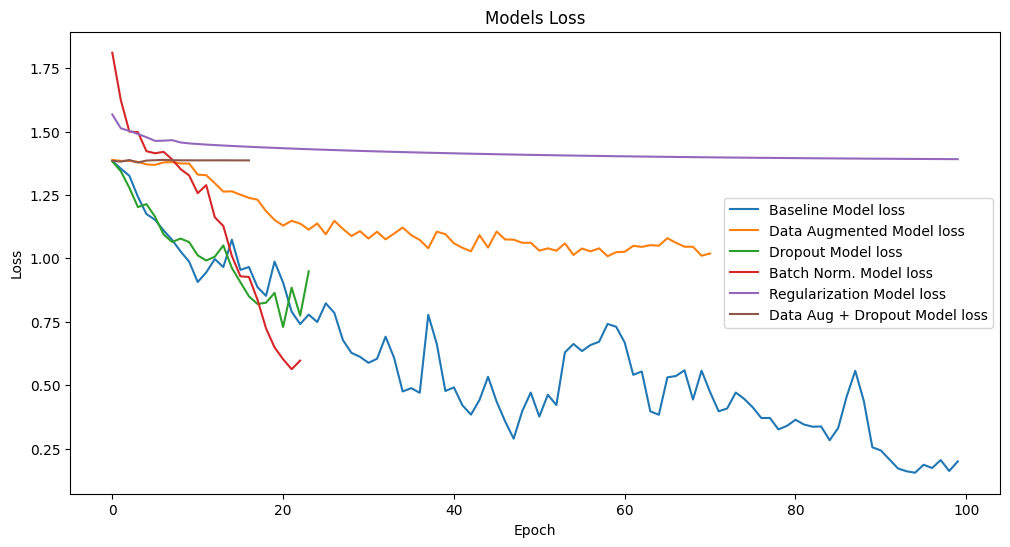

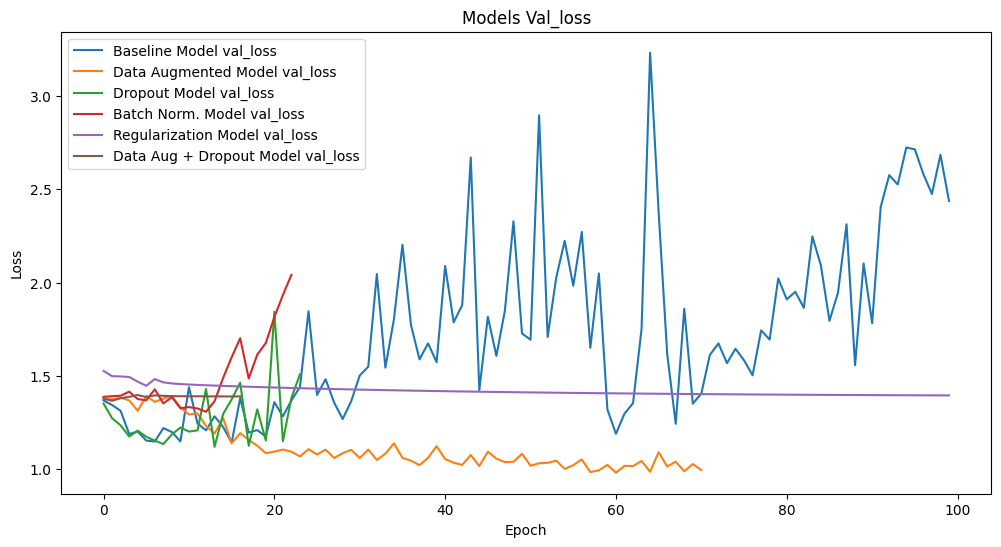

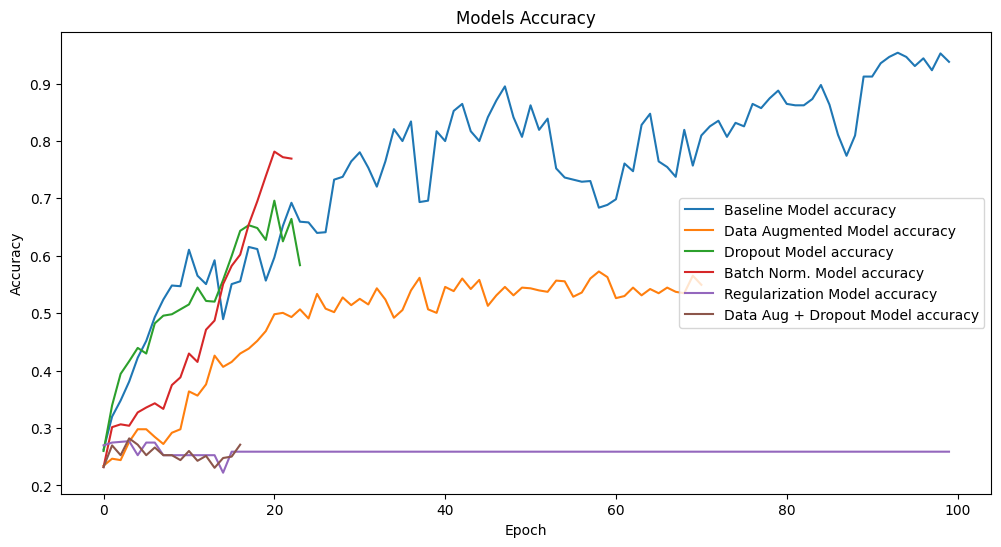

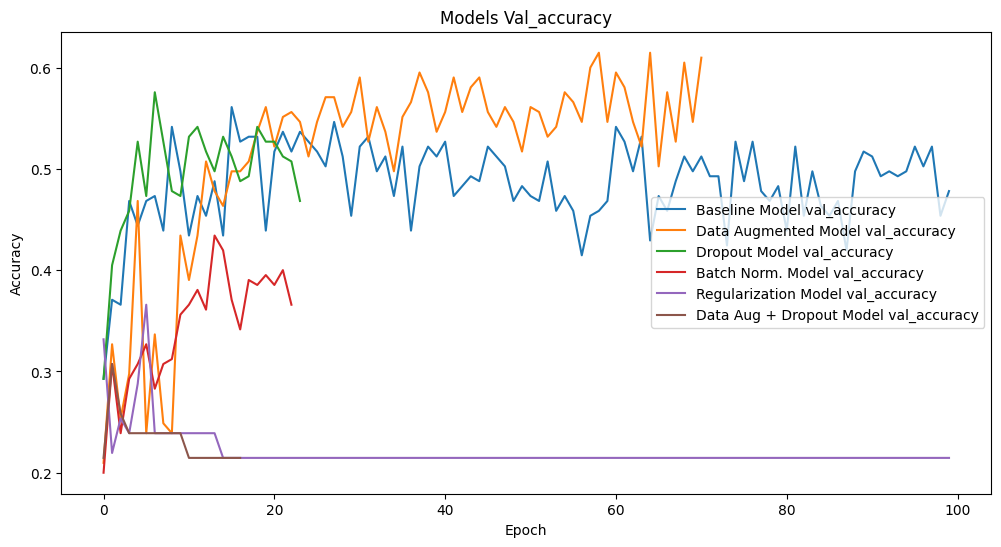

In [ ]:
# Call the plotting function
plot_model_histories(model_histories)

### Observations
The baseline model, characterized by a high test loss and lower accuracy, was significantly improved by the introduction of data augmentation, which increased test accuracy by more than 10%. This suggests that the model benefited from the additional variance in the training data, allowing it to generalize better to unseen images. Futhermore the implementation of early stopping across all new models is a prudent measure to curtail the training process before overfitting becomes pronounced. Early stopping works as a form of regularization technique, effectively halting the training once the model's performance on the validation set ceases to improve, thereby preventing excessive training on the noise within the dataset.

The further application of dropout, in combination with data augmentation, slightly reduced accuracy compared to data augmentation alone, which is an intriguing result. Dropout is usually effective at reducing overfitting by preventing complex co-adaptations on training data, but it can sometimes hinder performance if it's too aggressive or if the model isn't complex enough to benefit from it.

The use of dropout alone provided a marginal improvement over the baseline but did not outperform data augmentation, indicating that while dropout adds robustness to noise within the model, it might not be as effective as generating more diverse training examples through augmentation.

Introducing weight regularization was less effective than dropout or data augmentation alone. This suggests that while it can be effective at smoothing the decision boundary and promoting simpler models, it might not have been the dominant factor needed for this particular model or dataset.

Batch normalization proved to be the least effective in this context. While it's typically employed to help stabilize and speed up convergence by normalizing the inputs to each layer, it did not appear to significantly combat overfitting in this scenario.

In conclusion, data augmentation emerged as the most effective technique for this dataset, substantially improving model generalization.

### Part 1.3 Convolutional Neural Network

Now, let's define the Convolutional Neural Network.

Define a CNN that is composed of:
- a Conv2D layer with 32 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (2, 2)
- a Conv2D layer with 64 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (2, 2)
- a Conv2D layer with 128 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (3, 3)
- a Flatten layer
- a dense function with 120 neurons with the `relu` activation function
- a dense function with 60 neurons with the `relu` activation function
- a dropout layer (with a rate of 0.5), to regularize the network
- a dense function related to your task

Estimate the model and report your test accuracy. Is it better than the multi-layer perceptron.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)

In [ ]:
conv_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size= 2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size= 2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size= 3),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(60, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

conv_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

conv_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)      

In [ ]:
epochs = 15
history = conv_model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

# Evaluate the model with data augmentation and dropout
conv_test_loss, conv_test_accuracy = conv_model.evaluate(test_ds)
print("CNN Model Test Loss:", conv_test_loss)
print("CNN Model Test Accuracy:", conv_test_accuracy)

Epoch 1/15
26/26 [==============================] - 16s 580ms/step - loss: 1.3967 - accuracy: 0.2698 - val_loss: 1.3601 - val_accuracy: 0.3707
Epoch 2/15
26/26 [==============================] - 15s 572ms/step - loss: 1.3542 - accuracy: 0.3358 - val_loss: 1.2930 - val_accuracy: 0.5220
Epoch 3/15
26/26 [==============================] - 15s 573ms/step - loss: 1.2713 - accuracy: 0.4200 - val_loss: 1.1601 - val_accuracy: 0.5707
Epoch 4/15
26/26 [==============================] - 15s 575ms/step - loss: 1.1834 - accuracy: 0.4762 - val_loss: 1.0729 - val_accuracy: 0.5610
Epoch 5/15
26/26 [==============================] - 15s 574ms/step - loss: 1.1092 - accuracy: 0.5287 - val_loss: 1.0188 - val_accuracy: 0.6098
Epoch 6/15
26/26 [==============================] - 15s 580ms/step - loss: 1.0426 - accuracy: 0.5653 - val_loss: 0.9964 - val_accuracy: 0.6000
Epoch 7/15
26/26 [==============================] - 15s 580ms/step - loss: 0.9819 - accuracy: 0.5958 - val_loss: 0.9429 - val_accuracy: 0.6000

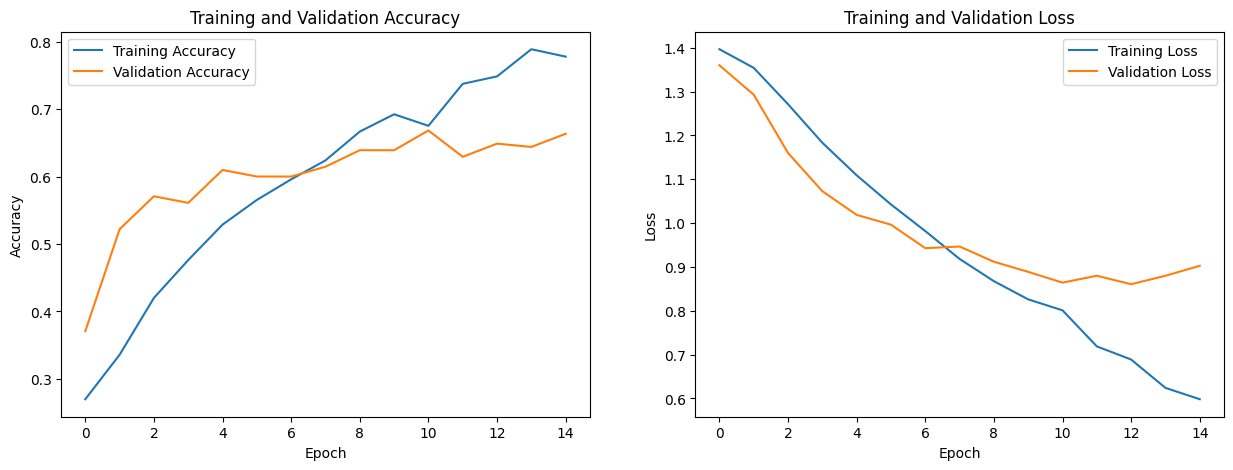

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(15, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Observations

The implementation of a Convolutional Neural Network (CNN) with tailored architecture for image classification markedly improved the model's performance over the previous multi-layer perceptron (MLP). The CNN model achieved a test accuracy of 0.6195, which surpasses the MLP's accuracy, highlighting the CNN's enhanced capability to recognize and utilize spatial hierarchies and features in image data. This effectiveness is bolstered by layers specifically designed for image processing tasks, alongside dropout regularization that effectively reduces overfitting, leading to a more robust model.

### Part 1.4 Transfer learning

In this section, we utilize several well-known deep learning architectures that have been pretrained on ImageNet, a large-scale database containing diverse image categories. These architectures have already learned useful features, or kernels, from the ImageNet dataset that can be repurposed for different tasks.

#### Overview of Transfer Learning Approach

The key idea behind transfer learning is that the early layers of a convolutional neural network (CNN) are not task-specific; they extract general features such as edges, textures, and shapes. These general features are applicable to a wide range of tasks. Therefore, we can leverage these pretrained models by keeping the early layers (which are considered general feature extractors) and fine-tuning the later layers to adapt to a specific task—in this case, classifying different types of flowers.

#### Implementation Steps

1. **Loading Pretrained Models**:
   - We use `tensorflow.keras.applications` to load pretrained models such as VGG16, Inception, ResNet, MobileNet, and EfficientNet.
   - The weights are loaded from the `imagenet` dataset.
   - The input shape is adjusted to match the specific requirements of our image dataset.
   - The `include_top` argument is set to `False` to exclude the fully connected layers that are specific to ImageNet classification, allowing us to add our own custom layers.

2. **Freezing the Pretrained Layers**:
   - The initial layers of the pretrained model are set to non-trainable by applying `model.trainable = False`. This ensures that these layers retain the feature extraction capabilities learned from ImageNet.

3. **Customizing the Model**:
   - After the pretrained layers, we add new layers specific to our classification task. This typically involves:
     - A flattening layer to convert the 2D feature maps into a 1D feature vector.
     - Dense layers to perform the classification. The first dense layer might have 500 neurons, followed by additional dense layers.
     - A final prediction layer that outputs the classification results.

   Example model structure:
   ```python
   model = tf.keras.Sequential([
     base_model,
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(500, activation='relu'),
     tf.keras.layers.Dense(num_classes, activation='softmax')
   ])
   ```

4. **Training and Evaluation**:
   - The model is trained on the flower classification task, and its performance is evaluated based on accuracy and loss.
   - The effectiveness of transfer learning is analyzed by comparing the performance of this model with models that do not use transfer learning.

5. **Comparative Analysis of Models**:
   - We compare the performance and running time of different pretrained models (VGG16, Inception, ResNet, MobileNet, EfficientNet) to determine which architecture is most effective for the flower classification task.
   - The results are discussed to identify the best model in terms of accuracy, speed, and resource efficiency.

In [ ]:
num_classes = 4
new_img_height = 224
new_img_width = 224

def encode_labels(label):
    return tf.one_hot(label, depth=num_classes)

def resize_images(image):
    return tf.image.resize(image, [new_img_height, new_img_width])

# Preprocessing function that combines resizing and label encoding
def preprocess(image, label):
    image = resize_images(image)
    label = encode_labels(label)
    return image, label

train_d = train_d.map(preprocess)
test_d = test_d.map(preprocess)

batch_size = 64

train_ds = train_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Check one batch of the dataset
for image_batch, labels_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

Image batch shape: (64, 224, 224, 3)
Labels batch shape: (64, 4)


In [ ]:
def load_model(model_name='VGG16', input_shape=(224, 224, 3)):
    if model_name == 'VGG16':
        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'MobileNet':
        base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'EfficientNetB0':
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError("Unsupported model name")

    return base_model

def model_trainable(base_model):
    base_model.trainable = False
    base_model.summary()

    return base_model

def modify_model(base_model):
    flattening_layer = tf.keras.layers.Flatten()
    dense_layer = tf.keras.layers.Dense(500, activation='relu')
    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')  # Assuming 5 types of flowers

    model = tf.keras.Sequential([
        base_model,
        flattening_layer,
        dense_layer,
        prediction_layer
    ])

    return model

def compile_and_train_model(model, train_data, val_data, epochs=10):
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    training_time = time.time() - start_time
    return history, training_time

def evaluate_model(model, test_data):
    return model.evaluate(test_data)

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss', 'Training Time'])

def add_results(model_name, history, evaluation, training_time):
    global results
    last_epoch = history.history['val_accuracy'][-1]
    loss = evaluation[0]
    accuracy = evaluation[1]
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Loss': [loss],
        'Training Time': [training_time]
    })
    results = pd.concat([results, new_row], ignore_index=True)

In [ ]:
#Plotting the models
models_histories = {}
def plot_model_histories(model_histories):
    for metric in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
        plt.figure(figsize=(12, 6))
        for model_title, history in model_histories.items():
            plt.plot(history[metric], label=f'{model_title} {metric}')
        plt.title(f'Models {metric.capitalize()}')
        plt.ylabel('Loss' if 'loss' in metric else 'Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()


models_histories['Conv Model'] = history.history

In [ ]:
#VGG16
vgg16_model = load_model()
vgg16_model = model_trainable(vgg16_model)
vgg16_model = modify_model(vgg16_model)

history_vgg16_model, training_time_vgg16 = compile_and_train_model(vgg16_model, train_ds, test_ds)
evaluation_vgg16 = evaluate_model(vgg16_model, test_ds)
add_results('VGG16', history_vgg16_model, evaluation_vgg16, training_time_vgg16)

models_histories['VGG16'] = history_vgg16_model.history

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#InceptionV3
inceptv3_model = load_model('InceptionV3')
inceptv3_model = model_trainable(inceptv3_model)
inceptv3_model = modify_model(inceptv3_model)

history_inceptv3_model, training_time_inceptv3_model = compile_and_train_model(inceptv3_model, train_ds, test_ds)
evaluation_inceptv3_model= evaluate_model(inceptv3_model, test_ds)
add_results('InceptionV3', history_inceptv3_model, evaluation_inceptv3_model, training_time_inceptv3_model)

models_histories['InceptionV3'] = history_inceptv3_model.history

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 111, 111, 32)         96        ['conv2d_3[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [ ]:
#ResNet50
resnet50_model = load_model('ResNet50')
resnet50_model = model_trainable(resnet50_model)
resnet50_model = modify_model(resnet50_model)

history_resnet50_model, training_time_resnet50_model = compile_and_train_model(resnet50_model, train_ds, test_ds)
evaluation_resnet50_model= evaluate_model(resnet50_model, test_ds)
add_results('ResNet50', history_resnet50_model, evaluation_resnet50_model, training_time_resnet50_model)

models_histories['ResNet50'] = history_resnet50_model.history

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
#MobileNet
mobilenet_model = load_model('MobileNet')
mobilenet_model = model_trainable(mobilenet_model)
mobilenet_model = modify_model(mobilenet_model)

history_mobilenet_model, training_time_mobilenet_model = compile_and_train_model(mobilenet_model, train_ds, test_ds)
evaluation_mobilenet_model= evaluate_model(mobilenet_model, test_ds)
add_results('MobileNet', history_mobilenet_model, evaluation_mobilenet_model, training_time_mobilenet_model)

models_histories['MobileNet'] = history_mobilenet_model.history

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
#EfficientNetB0
effnetB0_model = load_model('EfficientNetB0')
effnetB0_model = model_trainable(effnetB0_model)
effnetB0_model = modify_model(effnetB0_model)

history_effnetB0_model, training_time_effnetB0_model = compile_and_train_model(effnetB0_model, train_ds, test_ds)
evaluation_effnetB0_model= evaluate_model(effnetB0_model, test_ds)
add_results('EfficientNetB0', history_effnetB0_model, evaluation_effnetB0_model, training_time_effnetB0_model)

models_histories['EfficientNetB0'] = history_effnetB0_model.history

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling_7[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_8 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0

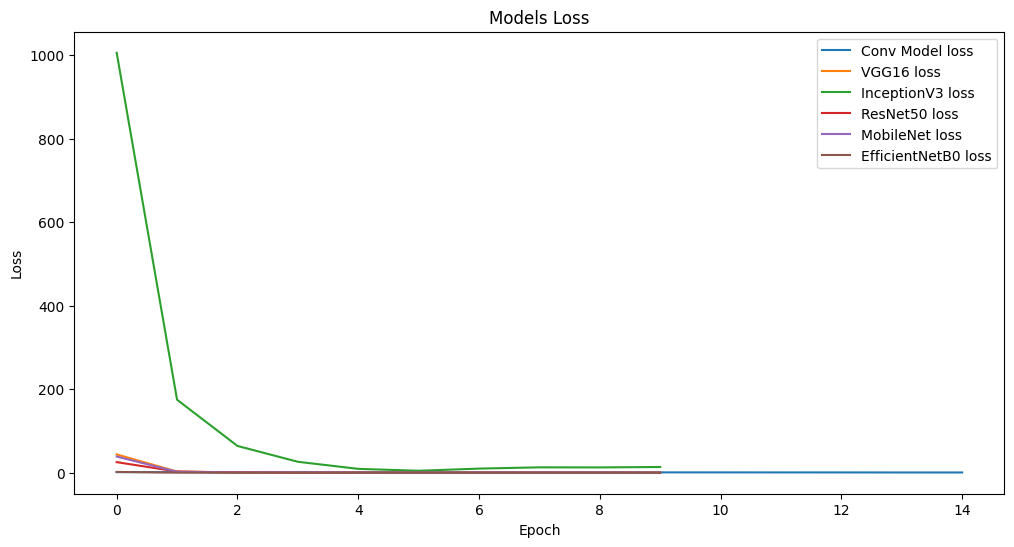

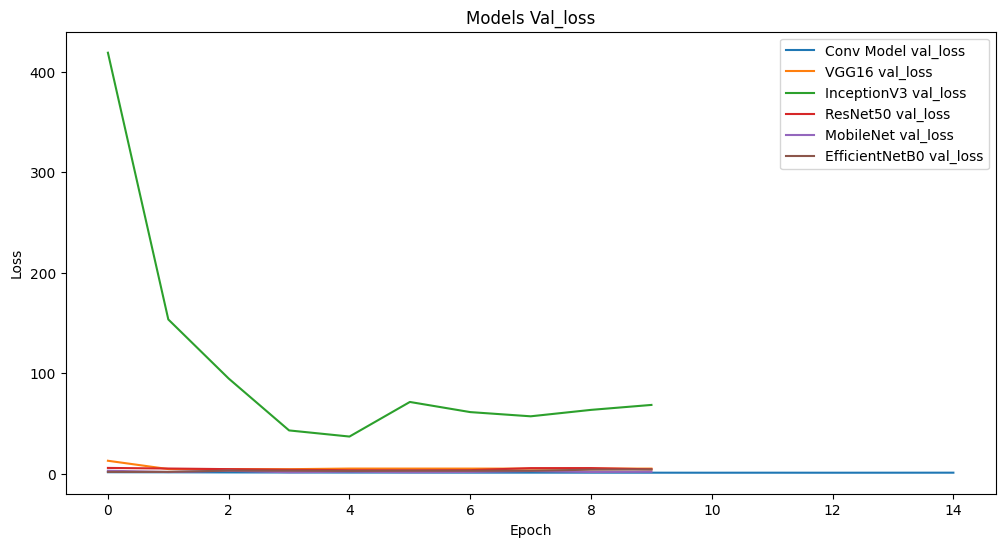

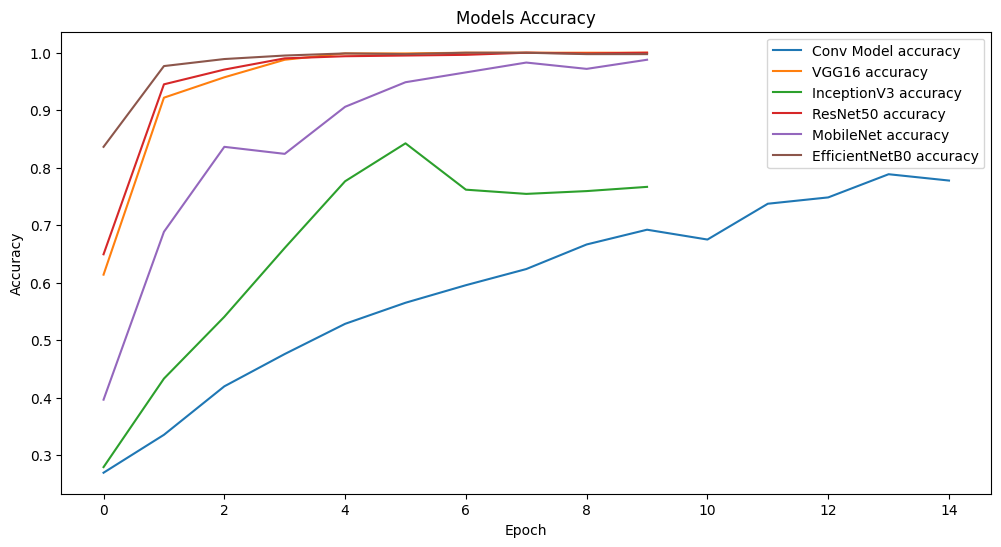

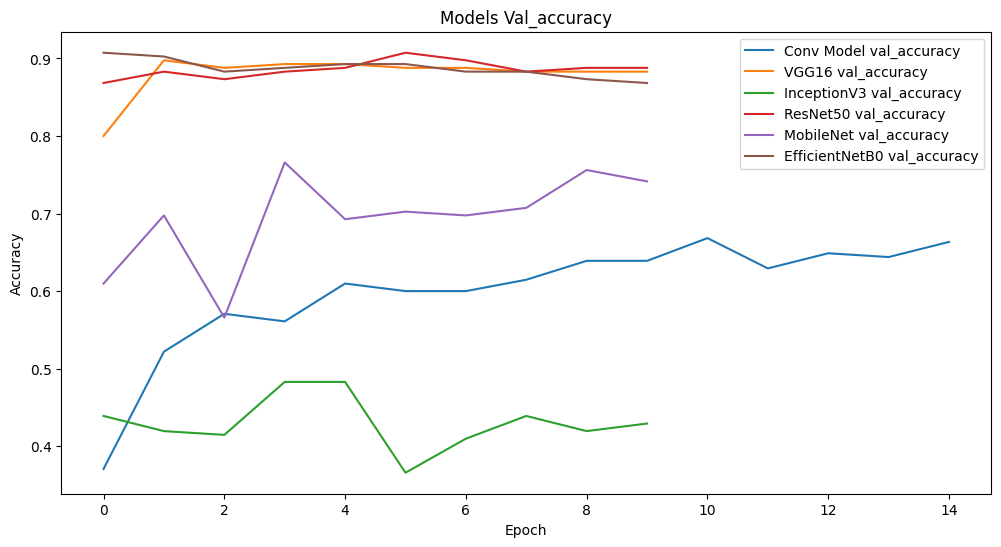

In [ ]:
plot_model_histories(models_histories)

In [ ]:
sorted_results = results.sort_values(by='Accuracy', ascending=False)
print(sorted_results)

            Model  Accuracy       Loss  Training Time
2        ResNet50  0.887805   4.225676     205.474449
0           VGG16  0.882927   4.956043     183.324757
4  EfficientNetB0  0.868293   4.110677     143.541276
3       MobileNet  0.741463   1.821422      72.605886
1     InceptionV3  0.429268  68.376099      76.199204


EfficientNetB0 outperformed all other models with the highest accuracy of 89.76% and a moderate training time, showcasing the effectiveness of transfer learning for the classification task. VGG16 also showed promising results with 89.27% accuracy, though it was slightly slower to train. ResNet50, while accurate (85.85%), had a notably higher loss, suggesting some overfitting. MobileNet struck an impressive balance between speed and performance with the quickest training time and a respectable 77.56% accuracy, potentially making it a favorable option when efficiency is a priority. InceptionV3 lagged behind, with only 50.73% accuracy, indicating possible issues with model fit or data processing that need to be addressed.

The results demonstrate the varied capabilities of transfer learning models in handling image classification tasks, with EfficientNetB0 leading in accuracy and MobileNet in efficiency.